# simple linear regression

In simple linear regression, we assume that we have one to one linear relationship between two properties based on some formula. thus if you know predict value of property Y with respect to value of property X.
The examples of such relationships are 
- Cost vs quantity
- Cost vs quality
- fuel vs distance

lets take an example of serivce charge of home delivery service of local shop. In it as the distance grows the cost grows and we are going to predict the service charge using ML. 

In [4]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib import rcParams
import sklearn 
import seaborn as sns


sns.set_style("whitegrid")
sns.set_context("poster")

## training data set

In [5]:
# distance
D = [[1], [2], [5], [7], [8], [9]]
# Charge
C = [[7], [9], [13], [16], [18], [20]]

```
NOTE: every set of value(s) are stored in a different array, we will learn more about them in future.   
```

lets plot and view how it looks on graph

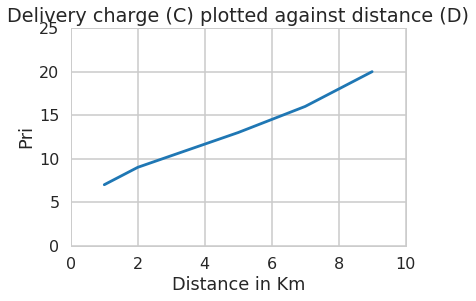

In [6]:
plt.figure()
plt.title('Delivery charge (C) plotted against distance (D)')
plt.xlabel('Distance in Km')
plt.ylabel("Pri")
           # distance
D = [[1], [2], [5], [7], [8], [9]]
# Charge
C = [[7], [9], [13], [16], [18], [20]]
plt.plot(D, C)
plt.axis([0, 10, 0, 25])
plt.grid(True)
plt.show()

we can also verify that as the distance is increasing the price is also increasing. 

In [28]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(D, C)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

lets predict the service charge 

In [29]:
dist = 11
print ('The service charge should be: Rs %.2f' % model.predict([[dist]]))

The service charge should be: Rs 22.69


In [31]:
dist = 2
print ('The service charge should be: Rs %.2f' % model.predict([[dist]]))
dist = 9
print ('The service charge should be: Rs %.2f' % model.predict([[dist]]))

The service charge should be: Rs 8.62
The service charge should be: Rs 19.56


So, you see that their is a bit of error in our predicted values from the original values.  

## Example 2: Daily Female Births in California

This dataset describes the number of daily female births in California in 1959. The units are a count and there are 365 observations. The source of the dataset is credited to Newton (1988).
URL: https://datamarket.com/data/set/235k/daily-total-female-births-in-california-1959#!ds=235k&display=line

### Step 1 - Load the dataset

            Daily total female births
Date                                 
1959-12-27                         37
1959-12-28                         52
1959-12-29                         48
1959-12-30                         55
1959-12-31                         50


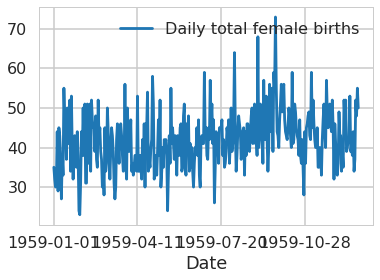

In [15]:
from pandas import Series
from matplotlib import pyplot
series = pd.read_csv('../files/daily-total-female-births-in-cal.csv', header=0)
series=series.set_index('Date')
print(series.tail())
series.plot()
plt.show()

### Model Selection

You must select a model.

This is where the bulk of the effort will be in preparing the data, performing analysis, and ultimately selecting a model and model hyperparameters that best capture the relationships in the data.

In this case, we can arbitrarily select an autoregression model (AR) with a lag of 6 on the differenced dataset.

We can demonstrate this model below.

First, the data is transformed by differencing, with each observation transformed as:

In [ ]:
value(t) = obs(t) - obs(t - 1)

Next, the AR(6) model is trained on 66% of the historical data. The regression coefficients learned by the model are extracted and used to make predictions in a rolling manner across the test dataset.

As each time step in the test dataset is executed, the prediction is made using the coefficients and stored. The actual observation for the time step is then made available and stored to be used as a lag variable for future predictions.

/home/mayank/.local/lib64/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Test MSE: 52.696


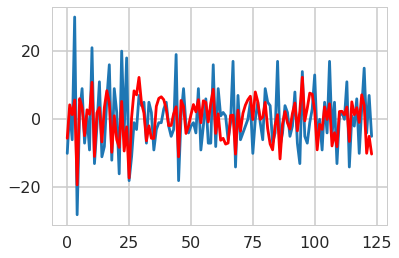

In [5]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

series = pd.read_csv('../files/daily-total-female-births-in-cal.csv', header=0)
series=series.set_index('Date')

# split dataset
X = difference(series.values)

size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=6, disp=False)
window = model_fit.k_ar
coef = model_fit.params
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

### Finalize and Save Time Series Forecast Model

Once the model is selected, we must finalize it.

This means save the salient information learned by the model so that we do not have to re-create it every time a prediction is needed.

This involves first training the model on all available data and then saving the model to file.

The statsmodels implementations of time series models do provide built-in capability to save and load models by calling save() and load() on the fit ARResults object.

For example, the code below will train an AR(6) model on the entire Female Births dataset and save it using the built-in save() function, which will essentially pickle the ARResults object.

The differenced training data must also be saved, both the for the lag variables needed to make a prediction, and for knowledge of the number of observations seen, required by the predict() function of the ARResults object.

Finally, we need to be able to transform the differenced dataset back into the original form. To do this, we must keep track of the last actual observation. This is so that the predicted differenced value can be added to it.

In [20]:
# fit an AR model and save the whole model to file
from pandas import Series
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.ar_model import ARResults
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = pd.read_csv('../files/daily-total-female-births-in-cal.csv', header=0)
series=series.set_index('Date')

X = difference(series.values)
# fit model
model = AR(X)
model_fit = model.fit(maxlag=6, disp=False)
# save model to file
model_fit.save('ar_model.pkl')
# save the differenced dataset
numpy.save('ar_data.npy', X)
# save the last ob
numpy.save('ar_obs.npy', [series.values[-1]])

This code will create a file ar_model.pkl that you can load later and use to make predictions.

The entire training dataset is saved as ar_data.npy and the last observation is saved in the file ar_obs.npy as an array with one item.

The NumPy save() function is used to save the differenced training data and the observation. The load() function can then be used to load these arrays later.

The snippet below will load the model, differenced data, and last observation.

In [21]:
# load the AR model from file
from statsmodels.tsa.ar_model import ARResults
import numpy
loaded = ARResults.load('ar_model.pkl')
print(loaded.params)
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[[50]]


I think this is good for most cases, but is also pretty heavy. You are subject to changes to the statsmodels API.

My preference is to work with the coefficients of the model directly, as in the case above, evaluating the model using a rolling forecast.

In this case, you could simply store the model coefficients and later load them and make predictions.

The example below saves just the coefficients from the model, as well as the minimum differenced lag values required to make the next prediction and the last observation needed to transform the next prediction made.

In [24]:
# fit an AR model and manually save coefficients to file
from pandas import Series
from statsmodels.tsa.ar_model import AR
import numpy

# create a difference transform of the dataset
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return numpy.array(diff)

# load dataset
series = pd.read_csv('../files/daily-total-female-births-in-cal.csv', header=0)
series=series.set_index('Date')

X = difference(series.values)
# fit model
window_size = 6
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False)
# save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)
# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)
# save the last ob
numpy.save('man_obs.npy', [series.values[-1]])

The coefficients are saved in the local file man_model.npy, the lag history is saved in the file man_data.npy, and the last observation is saved in the file man_obs.npy.

These values can then be loaded again as follows:

In [25]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy')
print(coef)
lag = numpy.load('man_data.npy')
print(lag)
last_ob = numpy.load('man_obs.npy')
print(last_ob)

[ 0.12129822 -0.75275857 -0.612367   -0.51097172 -0.4176669  -0.32116469
 -0.23412997]
[[-10]
 [  3]
 [ 15]
 [ -4]
 [  7]
 [ -5]]
[[50]]


### Make a Time Series Forecast

Making a forecast involves loading the saved model and estimating the observation at the next time step.

If the ARResults object was serialized, we can use the predict() function to predict the next time period.

The example below shows how the next time period can be predicted.

The model, training data, and last observation are loaded from file.

The period is specified to the predict() function as the next time index after the end of the training data set. This index may be stored directly in a file instead of storing the entire training data, which may be an efficiency.

The prediction is made, which is in the context of the differenced dataset. To turn the prediction back into the original units, it must be added to the last known observation.

In [26]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import ARResults
import numpy
# load model
model = ARResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data))
# transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


We can also use a similar trick to load the raw coefficients and make a manual prediction.
The complete example is listed below.

In [27]:
# load a coefficients and from file and make a manual prediction
import numpy

def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat

# load model
coef = numpy.load('man_model.npy')
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
# make prediction
prediction = predict(coef, lag)
# transform prediction
yhat = prediction + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 46.755211


#### Update Forecast Model

Our work is not done.

Once the next real observation is made available, we must update the data associated with the model.

Specifically, we must update:

The differenced training dataset used as inputs to make the subsequent prediction.
The last observation, providing a context for the predicted differenced value.
Let’s assume the next actual observation in the series was 48.
The new observation must first be differenced with the last observation. It can then be stored in the list of differenced observations. Finally, the value can be stored as the last observation.

In the case of the stored AR model, we can update the ar_data.npy and ar_obs.npy files. The complete example is listed below:

In [28]:
# update the data for the AR model with a new obs
import numpy
# get real observation
observation = 48
# load the saved data
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# update and save differenced observation
diffed = observation - last_ob[0]
data = numpy.append(data, [diffed], axis=0)
numpy.save('ar_data.npy', data)
# update and save real observation
last_ob[0] = observation
numpy.save('ar_obs.npy', last_ob)

In [29]:
# update the data for the manual model with a new obs
import numpy
# get real observation
observation = 48
# update and save differenced observation
lag = numpy.load('man_data.npy')
last_ob = numpy.load('man_obs.npy')
diffed = observation - last_ob[0]
lag = numpy.append(lag[1:], [diffed], axis=0)
numpy.save('man_data.npy', lag)
# update and save real observation
last_ob[0] = observation
numpy.save('man_obs.npy', last_ob)

### Consider Storing All Observations
Generally, it is a good idea to keep track of all the observations.

This will allow you to:

Provide a context for further time series analysis to understand new changes in the data.
Train a new model in the future on the most recent data.
Back-test new and different models to see if performance can be improved.
For small applications, perhaps you could store the raw observations in a file alongside your model.

It may also be desirable to store the model coefficients and required lag data and last observation in plain text for easy review.

For larger applications, perhaps a database system could be used to store the observations.

## Example 3: Old Faithful Geyser

Old Faithful Geyser Data

Description:

     Waiting time between eruptions and the duration of the eruption
     for the Old Faithful geyser in Yellowstone National Park, Wyoming,
     USA.

     A data frame with observations on 2 variables.

eruptions  numeric  Eruption time in mins
waiting    numeric  Waiting time to next eruption

References:

     Hardle, W. (1991) Smoothing Techniques with Implementation in S.
     New York: Springer.

     Azzalini, A. and Bowman, A. W. (1990). A look at some data on the
     Old Faithful geyser. Applied Statistics 39, 357-365.

In [1]:
# Required Packages
import csv
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model

In [39]:
def get_data(file_name):
    """ Get Data from CSV file
    
    Reads the csv file and returns the lists of attributes. 
    """
    data = pd.read_csv(file_name).sort_values("eruptions")
    print(type(data))
    print(data)
    x_parameter = []
    y_parameter = []
    for x, y in zip(data['eruptions'],data['waiting']):
        x_parameter.append([float(x)])
        y_parameter.append(float(y))
    return x_parameter, y_parameter

In [40]:
A = get_data("../files/OldFaithfulGeyserData.csv")

<class 'pandas.core.frame.DataFrame'>
     S.No  eruptions  waiting
18     19      1.600       52
57     58      1.667       64
114   115      1.700       59
54     55      1.733       54
43     44      1.750       58
222   223      1.750       54
62     63      1.750       48
21     22      1.750       47
16     17      1.750       62
13     14      1.750       47
205   206      1.783       46
107   108      1.783       52
149   150      1.800       53
1       2      1.800       54
158   159      1.800       53
20     21      1.800       51
118   119      1.817       59
64     65      1.817       60
270   271      1.817       46
134   135      1.833       46
10     11      1.833       54
52     53      1.833       54
38     39      1.833       59
94     95      1.833       63
187   188      1.833       46
191   192      1.833       57
262   263      1.850       58
236   237      1.850       54
92     93      1.867       50
105   106      1.867       47
..    ...        ...      ...
14

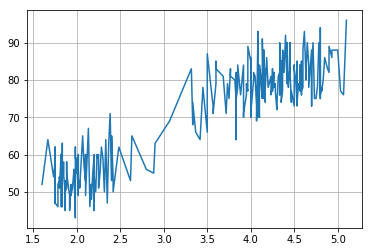

In [46]:
plt.figure()
plt.plot(A[0], A[1])
plt.grid(True)
plt.show()

In [24]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(A[0], A[1])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
dist = 3
print ('waiting time will be %.2f sec' % model.predict([[dist]]))

waiting time will be 65.66 sec
